# gwcosmo tutorial

While gwcosmo's main analyses are run from the command line, there are many useful utilities buried inside gwcosmo. This notebook will demonstrate how to use some of the most common ones.

## import useful packages

In [1]:
import numpy as np
import gwcosmo
import pickle
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Exploring cosmology functions

The standard_cosmology module contains some useful functions and classes. Cosmology is assumed to follow a flat $\Lambda$-CDM universe. The matter fraction, $\Omega_M$ can be easily changed.

In [3]:
cosmo = gwcosmo.utilities.standard_cosmology.fast_cosmology(Omega_m=0.3065)
zprior = gwcosmo.utilities.standard_cosmology.redshift_prior(Omega_m=0.3065)

### Converting between redshift and luminosity distance

In [4]:
# luminosity distance (Mpc) at redshift 0.1, assuming H0=70 km s-1 Mpc-1
lumdist = cosmo.dl_zH0(0.1,70)
print(lumdist)

460.07675594895255


In [5]:
z_array = np.linspace(0,1,1000)
H0_array = [30,50,70,90,110]

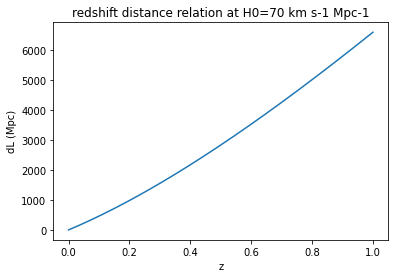

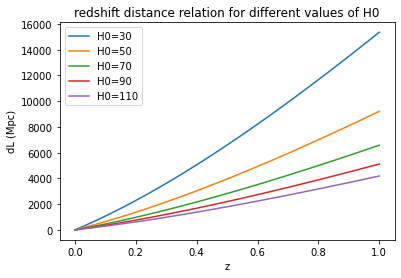

In [6]:
plt.figure()
plt.title('redshift distance relation at H0=70 km s-1 Mpc-1')
plt.plot(z_array, cosmo.dl_zH0(z_array,70))
plt.xlabel('z')
plt.ylabel('dL (Mpc)')

plt.figure()
plt.title('redshift distance relation for different values of H0')
for h in H0_array:
    plt.plot(z_array, cosmo.dl_zH0(z_array,h),label=f'H0={h}')
plt.xlabel('z')
plt.ylabel('dL (Mpc)')
plt.legend()
plt.show()

### Uniform in comoving redshift prior

It should be noted that many probability distributions in gwcosmo are not normalised by default, as the normalisation is irrelevant for the main analyses that gwcosmo carries out. If it is important for your specific analysis, make sure to check in advance.

In [7]:
z_array_extended = np.linspace(0,10,1000)

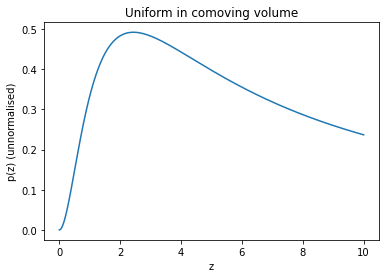

In [8]:
plt.figure()
plt.title('Uniform in comoving volume')
plt.plot(z_array_extended, zprior(z_array_extended))
plt.xlabel('z')
plt.ylabel('p(z) (unnormalised)')
plt.show()

## Exploring Schechter functions

The Schechter function in gwcosmo is written in terms of absolute magnitude. Try changing the magnitude bands below to see how the Schechter function changes in response.

In [9]:
# choose magnitude band ('W1', B', 'K', 'u', 'g', 'r', 'i' or 'z')
band = 'B'

# read in Schechter function parameters of corresponding band
sp = gwcosmo.utilities.schechter_params.SchechterParams(band)
print(sp.alpha,sp.Mstar)

# use the Schechter function parameters to create a absolute magnitude function
luminosity_func = gwcosmo.utilities.schechter_function.SchechterMagFunction(Mstar_obs=sp.Mstar,alpha=sp.alpha,phistar=1)

-1.21 -19.7


In [10]:
M_array = np.linspace(sp.Mmin,sp.Mmax,1000)

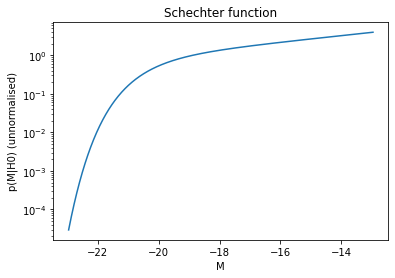

In [11]:
plt.figure()
plt.title('Schechter function')
plt.plot(M_array, luminosity_func(M_array,70)) # the schechter function also takes H0 as an argument
plt.xlabel('M')
plt.ylabel('p(M|H0) (unnormalised)')
plt.yscale('log')
plt.show()

## Exploring GW probability of detection

Gravitational wave selection effects are an important part of gwcosmo's analysis. Try reading in different Pdets available with gwcosmo and see how their distribution with redshift and $H_0$ differs.

In [12]:
# UPDATE FOR YOUR OWN PATH
file = '../gwcosmo/gwcosmo/data/O1PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform_snr_12.0.p'
pdet = pickle.load(open(file, 'rb'))

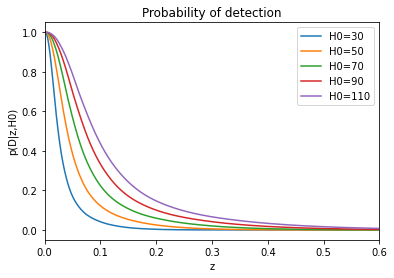

In [13]:
plt.figure()
plt.title('Probability of detection')
for h in H0_array:
    plt.plot(z_array,pdet.pD_zH0_eval(z_array,h),label=f'H0={h}')
plt.xlabel('z')
plt.ylabel('p(D|z,H0)')
plt.legend()
plt.xlim(0,0.6)
plt.show()

In [14]:
# locate the values that were used to generate Pdet, to use in the next section
mass_distribution = pdet.mass_distribution
mass_slope, psd, Mmin, Mmax, network_snr_threshold = pdet.alpha, pdet.asd, pdet.Mmin, pdet.Mmax, pdet.snr_threshold
mass_slope_2, beta, sigma_g, lambda_peak, mu_g, delta_m, b = pdet.alpha_2, pdet.beta, pdet.sigma_g, pdet.lambda_peak, pdet.mu_g, pdet.delta_m, pdet.b

hyper_params_dict = {'alpha':mass_slope,'alpha_2':mass_slope_2,'mmin':Mmin,'mmax':Mmax,'beta':beta,'sigma_g':sigma_g,'lambda_peak':lambda_peak,
                         'mu_g':mu_g,'delta_m':delta_m,'b':b}

## Exploring gravitational wave data

In [15]:
## Load posterior samples and skymap
samples_path = 'data/GW150914_GWTC-1.hdf5'
samples = gwcosmo.likelihood.posterior_samples.posterior_samples(cosmo,samples_path,field=None)
skymap_path = 'data/GW150914_skymap.fits.gz'
skymap = gwcosmo.likelihood.skymap.skymap(skymap_path)

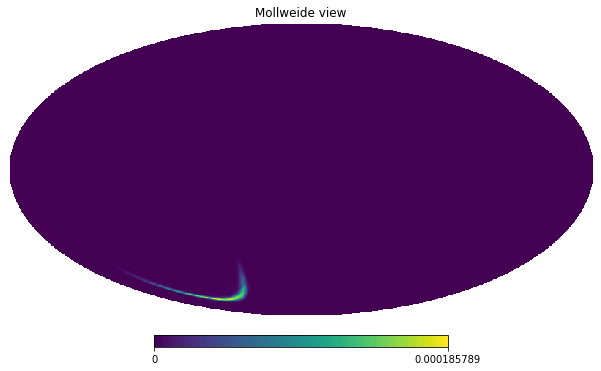

In [16]:
# visualise GW skymap using healpy
hp.mollview(skymap.prob,nest=True)

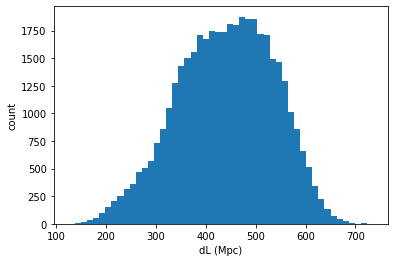

In [17]:
# visualise GW luminosity distance

plt.figure()
plt.hist(samples.distance,bins=50)
plt.xlabel('dL (Mpc)')
plt.ylabel('count')
plt.show()

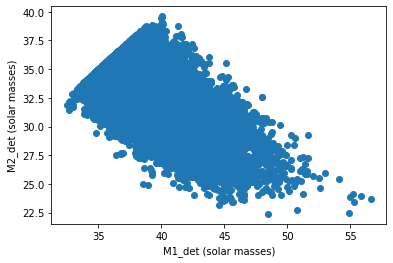

In [18]:
# visualise GW masses (detector frame)

plt.figure()
plt.scatter(samples.mass_1,samples.mass_2)
plt.xlabel('M1_det (solar masses)')
plt.ylabel('M2_det (solar masses)')
plt.show()

### The line-of-sight redshift distribution of a GW event

Try changing npixels and sky_area in the line below to see how changing the resolution of the analysis impacts the line-of-sight distribution of the GW event

In [19]:
# Find the required resolution of healpy map to give at least Npix pixels covering the sky_area of the event
Npix = 30
sky_area = 0.999
pixelated_samples = gwcosmo.likelihood.posterior_samples.make_pixel_px_function(samples, skymap, npixels=Npix, thresh=sky_area)
nside = pixelated_samples.nside

35 pixels to cover the 99.9% sky area (nside=8)


In [20]:
# downgrade the GW skymap to have the same resolution
low_res_skyprob = hp.pixelfunc.ud_grade(skymap.prob, nside, order_in='NESTED', order_out='NESTED')
low_res_skyprob = low_res_skyprob/np.sum(low_res_skyprob) #renormalise

In [21]:
# create a line-of-sight redshift/H0 distribution for each pixel (normalised to 1)
px_zH0 = {}
for pixel_index in pixelated_samples.indices:
    samp_ind = pixelated_samples.identify_samples(pixel_index, minsamps=100)

    px_zH0[pixel_index] = pixelated_samples.make_los_px_function(samp_ind,H0_array,hyper_params_dict,name=mass_distribution,reweight_samples=True)

angular radius: 0.06521271776725232 radians, No. samples: 7759
angular radius: 0.06521271776725232 radians, No. samples: 5936
angular radius: 0.06521271776725232 radians, No. samples: 3548
angular radius: 0.06521271776725232 radians, No. samples: 3355
angular radius: 0.06521271776725232 radians, No. samples: 3234
angular radius: 0.06521271776725232 radians, No. samples: 1646
angular radius: 0.06521271776725232 radians, No. samples: 1110
angular radius: 0.06521271776725232 radians, No. samples: 2411
angular radius: 0.06521271776725232 radians, No. samples: 1573
angular radius: 0.06521271776725232 radians, No. samples: 1221
angular radius: 0.06521271776725232 radians, No. samples: 111
angular radius: 0.09781907665087848 radians, No. samples: 2534
angular radius: 0.06521271776725232 radians, No. samples: 125
angular radius: 0.06521271776725232 radians, No. samples: 143
angular radius: 0.09781907665087848 radians, No. samples: 728
angular radius: 0.06521271776725232 radians, No. samples: 1

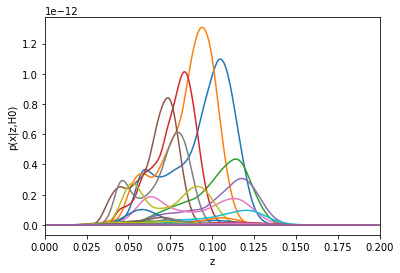

In [22]:
plt.figure()
for pixel_index in pixelated_samples.indices:
    plt.plot(z_array,px_zH0[pixel_index](z_array,70)*low_res_skyprob[pixel_index]) # low_res_skyprob retains correct normalisation between pixels
plt.xlabel('z')
plt.ylabel('p(x|z,H0)')
plt.xlim(0,0.2)
plt.show()

## Exploring the GLADE 2.4 galaxy catalogue

Make sure you have downloaded the GLADE 2.4 galaxy catalogue and placed it in the data directory (or update the path in the cell below to point to where you have stored it). 

In [23]:
catalog = gwcosmo.prior.catalog.OldStyleGLADE(catalog_file = 'data/glade.hdf5')

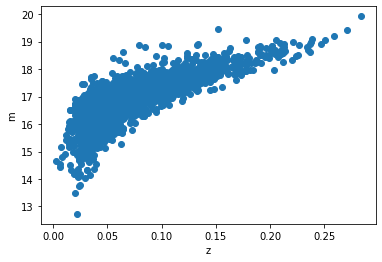

In [24]:
pixel_index = 1
sub_catalog = catalog.select_pixel(nside, pixel_index, nested=True)

# identify the redshift, right ascension, declination, apparent magnitude, and redshift uncertainty
# of every galaxy in this pixel
zs = sub_catalog['z'] 
ras = sub_catalog['ra']
decs = sub_catalog['dec']
ms = sub_catalog.get_magnitudes('B')
sigmazs = sub_catalog['sigmaz']

plt.figure()
plt.scatter(zs,ms)
plt.xlabel('z')
plt.ylabel('m')

plt.show()

In [25]:
# Find the number of galaxies in each pixel within GW150914's sky area
gal_number_density = np.zeros(len(low_res_skyprob))

for pixel_index in pixelated_samples.indices:
    sub_catalog = catalog.select_pixel(nside, pixel_index, nested=True)
    
    gal_number_density[pixel_index] = len(sub_catalog['z'])

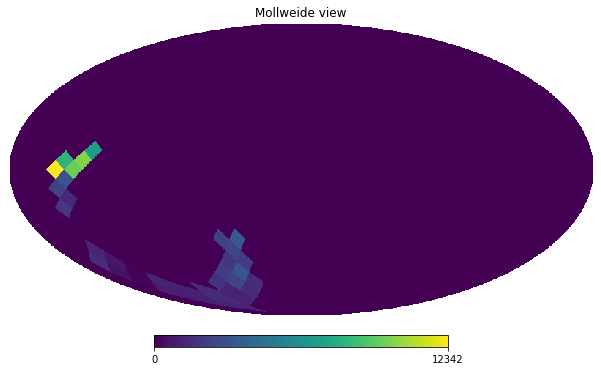

In [26]:
hp.mollview(gal_number_density,nest=True)

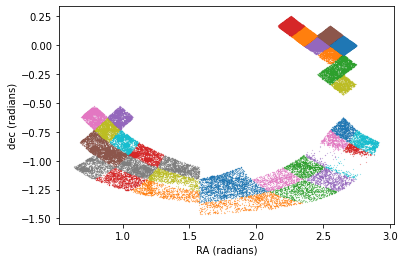

In [27]:
# scatter plot of the galaxies within GW150914's sky area

plt.figure()
for pixel_index in pixelated_samples.indices:
    sub_catalog = catalog.select_pixel(nside, pixel_index, nested=True)
    plt.scatter(sub_catalog['ra'],sub_catalog['dec'],marker='.',s=0.1)
plt.xlabel('RA (radians)')
plt.ylabel('dec (radians)')
plt.show()